Author: Nelson Liu

Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# SIR-Age-Travel Stratification Example

Example use case for multi-stratification:
1. SIR `x` Age = SIR_Age
2. SIR_Age `x` Travel = SIR_Age_Travel


In [1]:
# Libraries
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using GraphViz

## Define Ontology

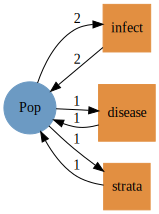

In [6]:
const infectious_ontology = LabelledPetriNet(
    [:Pop],
    :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
    :disease => (:Pop => :Pop),
    :strata => (:Pop => :Pop)
)

Graph(infectious_ontology)

## Define Base Models

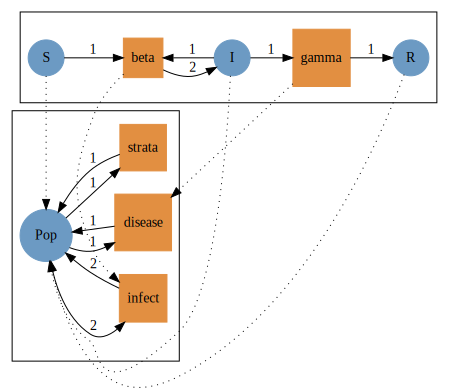

In [8]:
# SIR model
sir_uwd = @relation () where (S::Pop, I::Pop, R::Pop) begin
    infect(S, I, I, I)
    disease(I, R)
end

to_graphviz(sir_uwd, box_labels = :name, junction_labels = :variable)

tnames = [:beta, :gamma]
typed_sir = oapply_typed(infectious_ontology, sir_uwd, tnames)
Graph(typed_sir)

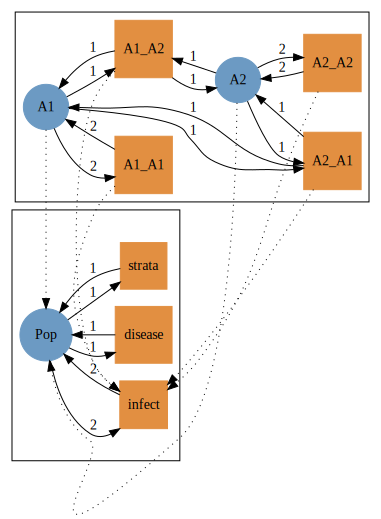

In [29]:
# Age (contact) model

N = 2
snames = [Symbol("A$i") for i in 1:N]

typed_age = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, snames)

Graph(typed_age)

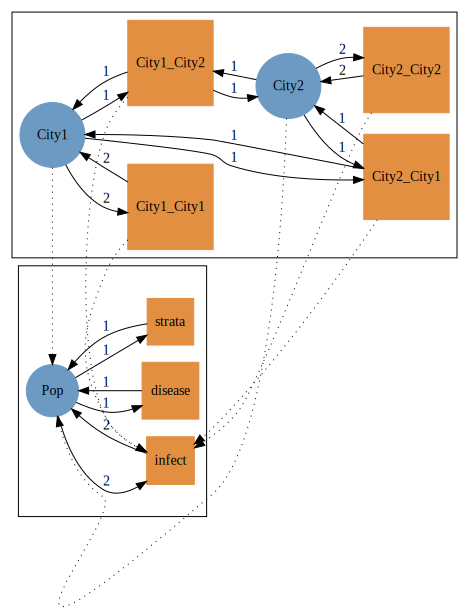

In [30]:
# Travel model
M = 2
snames = [Symbol("City$i") for i in 1:M]

# Use `pairwise_id_typed_petri` but note that all diagonal terms should be 0 since same-city travel is unphysical
typed_travel = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, snames)

Graph(typed_travel)

## First Stratification

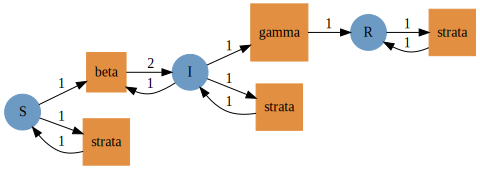

In [20]:
# Augment SIR model
# No self-interaction permitted
# (edit: need to add "strata" self-interaction now, not after 1st stratification)
typed_sir_aug = add_reflexives(
    typed_sir,
    # [[], [], []],
    [[:strata], [:strata], [:strata]],
    infectious_ontology
)

Graph(dom(typed_sir_aug))

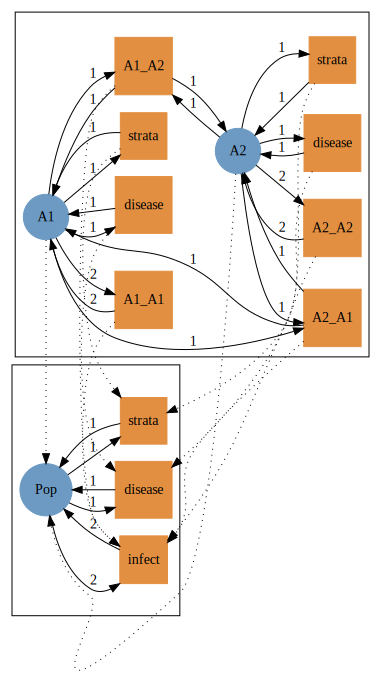

In [21]:
# Augment age (contact) model
# Permit all age states to have a "disease" self-interaction
# (edit: need to add "strata" self-interaction now, not after 1st stratification)
typed_age_aug = add_reflexives(
    typed_age,
    # repeat([[:disease]], N),
    repeat([[:disease, :strata]], N),
    infectious_ontology
)

# Graph(dom(typed_age_aug))
Graph(typed_age_aug)

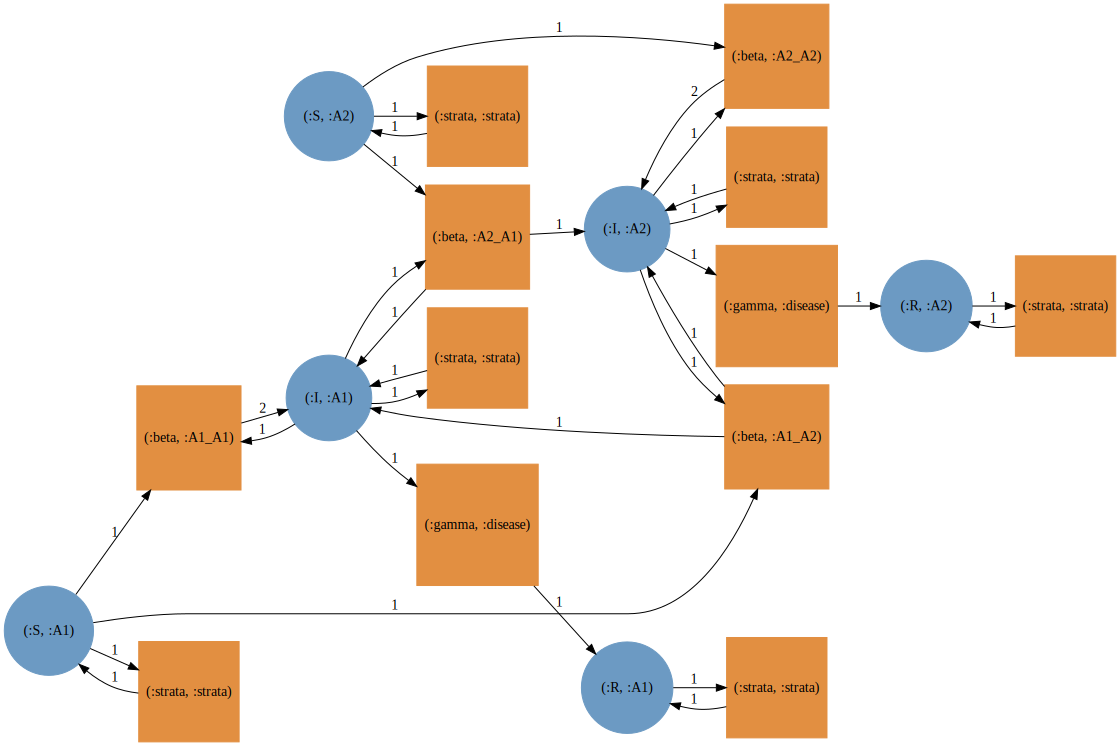

In [22]:
# Stratify SIR and Age models
typed_sir_age = typed_product(typed_sir_aug, typed_age_aug)

Graph(dom(typed_sir_age))

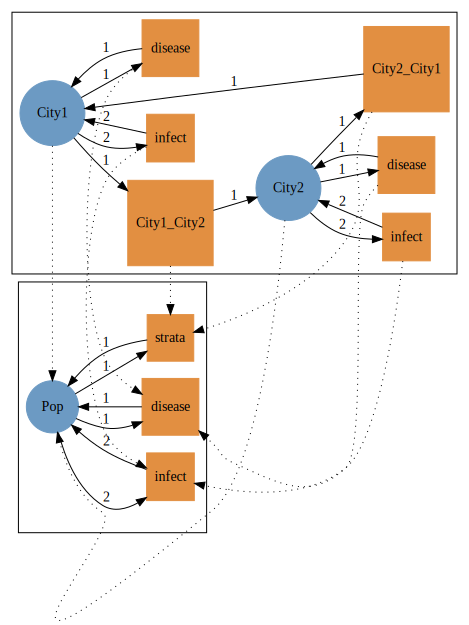

In [18]:
# Augment travel model
# Permit City states to have "infect" and "disease" self-interactions
typed_travel_aug = add_reflexives(
    typed_travel,
    repeat([[:infect, :disease]], M),
    infectious_ontology
)

Graph(typed_travel_aug)

Can't add "strata" reflexives to the SIR-Age model...

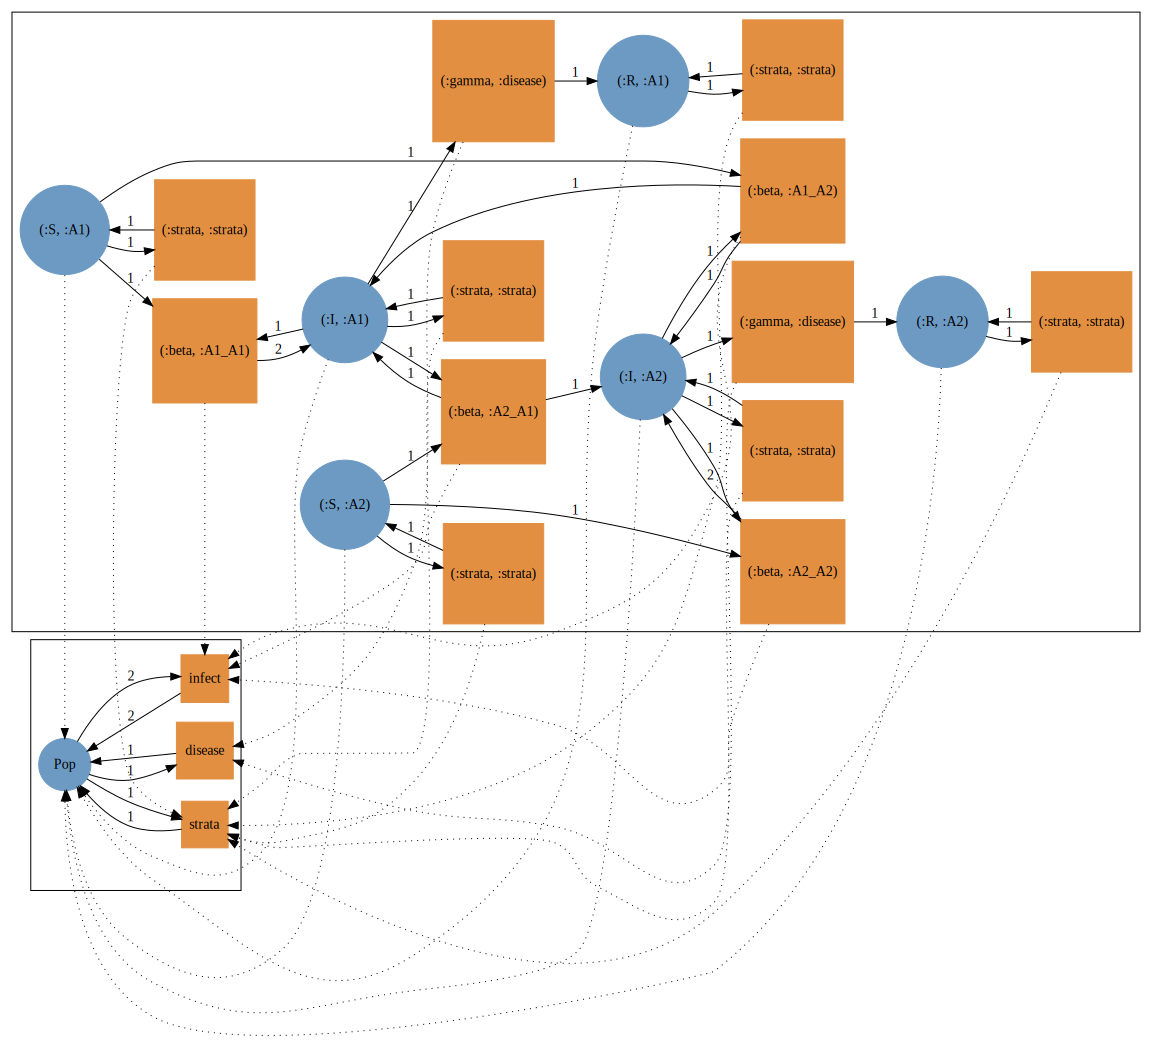

In [23]:
# Augment the SIR-Age model
# Permit "strata" self-interactions
# (edit: cannot add reflexives on an already stratified model)

typed_sir_age_aug = add_reflexives(
    typed_sir_age,
    # repeat([[:strata]], 3 * M),
    [[], [], []],
    infectious_ontology
)

Graph(typed_sir_age_aug)

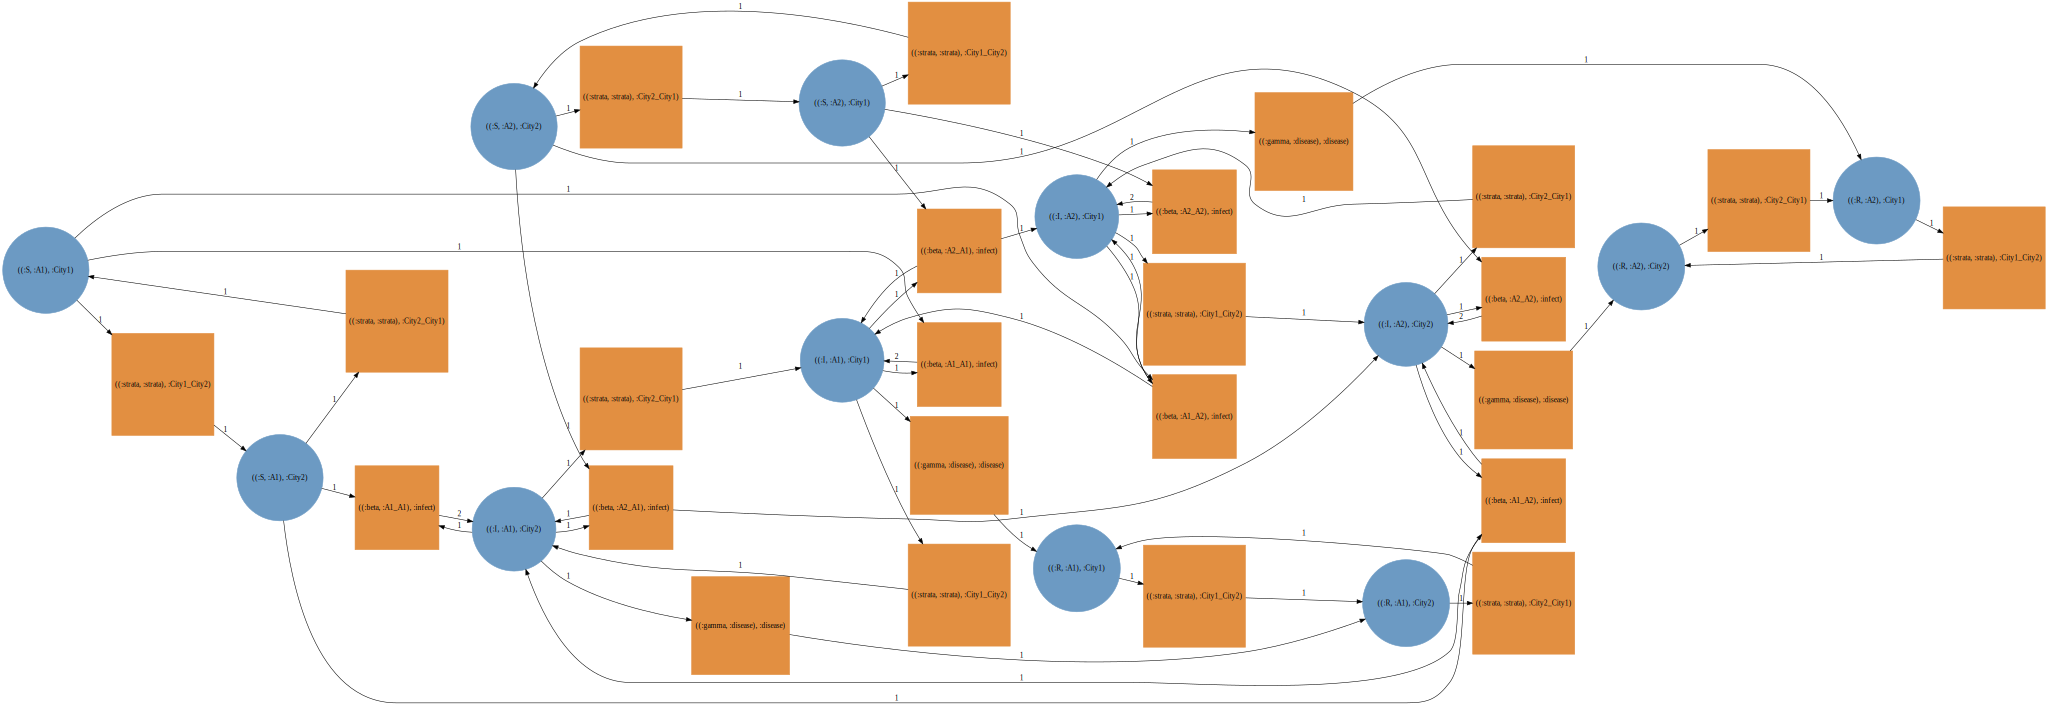

In [24]:
# Stratify the SIR-Age model with the travel model

typed_sir_age_travel = typed_product(typed_sir_age_aug, typed_travel_aug)
Graph(dom(typed_sir_age_travel))